# In Progress ...

# Introduction

## Intent

In this analysis, I will be investigating hourly energy demand and production data in Spain from 01/01/2015 - 12/31/2018. 

## Objectives

More specifically, I built a few different multivariate models(VAR, XGBRegressor, and a Deep Learning Network) in order to predict future hourly electricity price and demand with the hopes of better understanding price point mechanisms in the energy sector. Additionally, I created a few different consumer profiles highlighting electricity usage habits of different households.

The goal of this analysis was to outperform the predictions made by the Transmission Service Operator (TSO) for hourly energy price and demand in Spain. Models were designed to be able to make predictions accurately 3-months into the future for any given hour of any given day. By creating a superior model, I would be able to advise energy providers as to some strategies of how to implement greener alternatives to energy production(when demand is low) with the hopes that one day we'll be able to create net neutral emissions for electicity production in Spain.

I am also creating different consumer profiles based on electricity demand using a clustering algorithm. I aim to extract specific patterns of behavior by certain kinds of consumers in Spain to advise energy providers on potential programs that would help assist consumers effectively lower energy needs and costs w/ an incentives based program.

## Impact

# Table of Contents

1. Introduction
     - Intent
     - Objectives
     - Impact
2. Table of Contents
3. Data Overview
    - About the Data
    - Preview Data
    - Data Overview - Metrics
    - Data Overview - Exploratory Data Analysis
4. Consumer Profile Analysis
    - Results
5. Time Series Analysis
    - Results
6. Conclusion
    - Final Takeaways
    - Thoughts for future research

## Methods

Multivariate Time-Series Analysis
1. Selected Features using correlation matrix as criteria to select features
2. Ran Granger's Test of Causality to confirm there is some kind of a relationship between these features
3. Ran cointegration test to help establish the presence of a statistically significant connection between time series.
4. After establishing data was a good candidate for multivariate analysis, made data stationary and extracted different lag features
5. Developed models with the aim to beat predicrtions set by OTO

# Data Overview

## About the Data
'weather_features.csv': Contains hourly information about the weather conditions (e.g. temperature, wind speed, humidity, rainfall, qualitative desctiption) of 5 major cities of Spain (Madrid, Barcelona, Valencia, Seville and Bilbao).

'energy_dataset.csv': Contains hourly information about the generation of energy in Spain. In particular, there is info (in MW) about the amount of electricty generated by the various energy sources (fossil gas, fossil hard coal and wind energy dominate the energy grid), as well as about the total load (energy demand) of the national grid and the price of energy (€/MWh). Note: Since the generation of each energy type is in MW and the time-series contains hourly info, the number of each cell represent MWh.

[Data Source](https://www.kaggle.com/nicholasjhana/energy-consumption-generation-prices-and-weather)

## Preview Data

In [2]:
#Read in some libraries
import pandas as pd
import numpy as np
from IPython.display import Image

#Set notebook preferences - pandas
pd.set_option("display.max_columns", 101)

In [3]:
#Set path to clean aggregated data
path = r'C:\Users\kishe\Documents\Data Science\Projects\Python Projects\In Progress\Spain Hourly Energy Demand and Weather\Data\02_Cleaned_Data'

#Read in data
data = pd.read_csv(path + '/2020_0620_Weather_Energy.csv')

#Display data
display(data.head(10))
{
    "tags": [
        "remove_input",
    ]
}

,date_time,forecast_solar_day_ahead,forecast_wind_onshore_day_ahead,generation_biomass,generation_fossil_brown_coal/lignite,generation_fossil_gas,generation_fossil_hard_coal,generation_fossil_oil,generation_hydro_pumped_storage_consumption,generation_hydro_run-of-river_and_poundage,generation_hydro_water_reservoir,generation_nuclear,generation_other,generation_other_renewable,generation_solar,generation_waste,generation_wind_onshore,price_actual,price_day_ahead,temp,total_load_actual,total_load_forecast
0,2015-01-01 00:00:00,17.0,6436.0,447.0,329.0,4844.0,4821.0,162.0,863.0,1051.0,1899.0,7096.0,43.0,73.0,49.0,196.0,6378.0,65.41,50.10,30.814633,25385.0,26118.0
1,2015-01-01 01:00:00,16.0,5856.0,449.0,328.0,5196.0,4755.0,158.0,920.0,1009.0,1658.0,7096.0,43.0,71.0,50.0,195.0,5890.0,64.92,48.10,30.852860,24382.0,24934.0
2,2015-01-01 02:00:00,8.0,5454.0,448.0,323.0,4857.0,4581.0,157.0,1164.0,973.0,1371.0,7099.0,43.0,73.0,50.0,196.0,5461.0,64.48,47.33,30.108448,22734.0,23515.0
3,2015-01-01 03:00:00,2.0,5151.0,438.0,254.0,4314.0,4131.0,160.0,1503.0,949.0,779.0,7098.0,43.0,75.0,50.0,191.0,5238.0,59.32,42.27,30.091044,21286.0,22642.0
4,2015-01-01 04:00:00,9.0,4861.0,428.0,187.0,4130.0,3840.0,156.0,1826.0,953.0,720.0,7097.0,43.0,74.0,42.0,189.0,4935.0,56.04,38.41,30.192620,20264.0,21785.0
5,2015-01-01 05:00:00,4.0,4617.0,410.0,178.0,4038.0,3590.0,156.0,2109.0,952.0,743.0,7098.0,43.0,74.0,34.0,188.0,4618.0,53.63,35.72,29.973200,19905.0,21441.0
6,2015-01-01 06:00:00,3.0,4276.0,401.0,172.0,4040.0,3368.0,158.0,2108.0,961.0,848.0,7098.0,43.0,74.0,34.0,186.0,4397.0,51.73,35.13,30.035120,20010.0,21285.0
7,2015-01-01 07:00:00,12.0,3994.0,408.0,172.0,4030.0,3208.0,160.0,2031.0,983.0,1012.0,7099.0,43.0,72.0,35.0,189.0,3992.0,51.43,36.22,30.553880,20377.0,21545.0
8,2015-01-01 08:00:00,39.0,3602.0,413.0,177.0,4052.0,3335.0,161.0,2119.0,1001.0,1015.0,7098.0,43.0,73.0,54.0,198.0,3629.0,48.98,32.40,33.518480,20094.0,21443.0
9,2015-01-01 09:00:00,784.0,3212.0,419.0,177.0,4137.0,3437.0,163.0,2170.0,1041.0,1357.0,7097.0,43.0,74.0,743.0,198.0,3073.0,54.20,36.60,33.884960,20637.0,21560.0


{'tags': ['remove_input']}

## Data Overview - Metrics

**Data Description**

In [4]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
forecast_solar_day_ahead,35070.0,1438.825121,1677.661532,0.000000,69.000,576.0000,2635.000,5836.0000
forecast_wind_onshore_day_ahead,35070.0,5471.372512,3176.148983,237.000000,2979.000,4855.5000,7353.000,17430.0000
generation_biomass,35070.0,383.536128,85.348006,0.000000,333.000,367.0000,433.000,592.0000
generation_fossil_brown_coal/lignite,35070.0,448.060251,354.603125,0.000000,0.000,509.0000,757.000,999.0000
generation_fossil_gas,35070.0,5622.474309,2201.444741,0.000000,4126.000,4969.0000,6428.750,20034.0000
generation_fossil_hard_coal,35070.0,4256.296179,1961.968024,0.000000,2527.000,4474.0000,5839.000,8359.0000
generation_fossil_oil,35070.0,298.335358,52.518153,0.000000,263.000,300.0000,330.000,449.0000
generation_hydro_pumped_storage_consumption,35070.0,475.867237,792.594472,0.000000,0.000,68.0000,617.000,4523.0000
generation_hydro_run-of-river_and_poundage,35070.0,972.117536,400.740520,0.000000,637.000,906.0000,1250.000,2000.0000
generation_hydro_water_reservoir,35070.0,2605.122241,1835.141359,0.000000,1077.250,2165.0000,3757.000,9728.0000


**Data Information**

Features containing "ahead" or "forecast" refer to predictions made by the Transmission Service Operator (TSO) and part of the analyis will attempt to outperform these predictions.

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35070 entries, 0 to 35069
Data columns (total 22 columns):
 #   Column                                       Non-Null Count  Dtype  
---  ------                                       --------------  -----  
 0   date_time                                    35070 non-null  object 
 1   forecast_solar_day_ahead                     35070 non-null  float64
 2   forecast_wind_onshore_day_ahead              35070 non-null  float64
 3   generation_biomass                           35070 non-null  float64
 4   generation_fossil_brown_coal/lignite         35070 non-null  float64
 5   generation_fossil_gas                        35070 non-null  float64
 6   generation_fossil_hard_coal                  35070 non-null  float64
 7   generation_fossil_oil                        35070 non-null  float64
 8   generation_hydro_pumped_storage_consumption  35070 non-null  float64
 9   generation_hydro_run-of-river_and_poundage   35070 non-null  float64
 10

## Data Overview - Exploratory Data Analysis

**All Time Series Features**

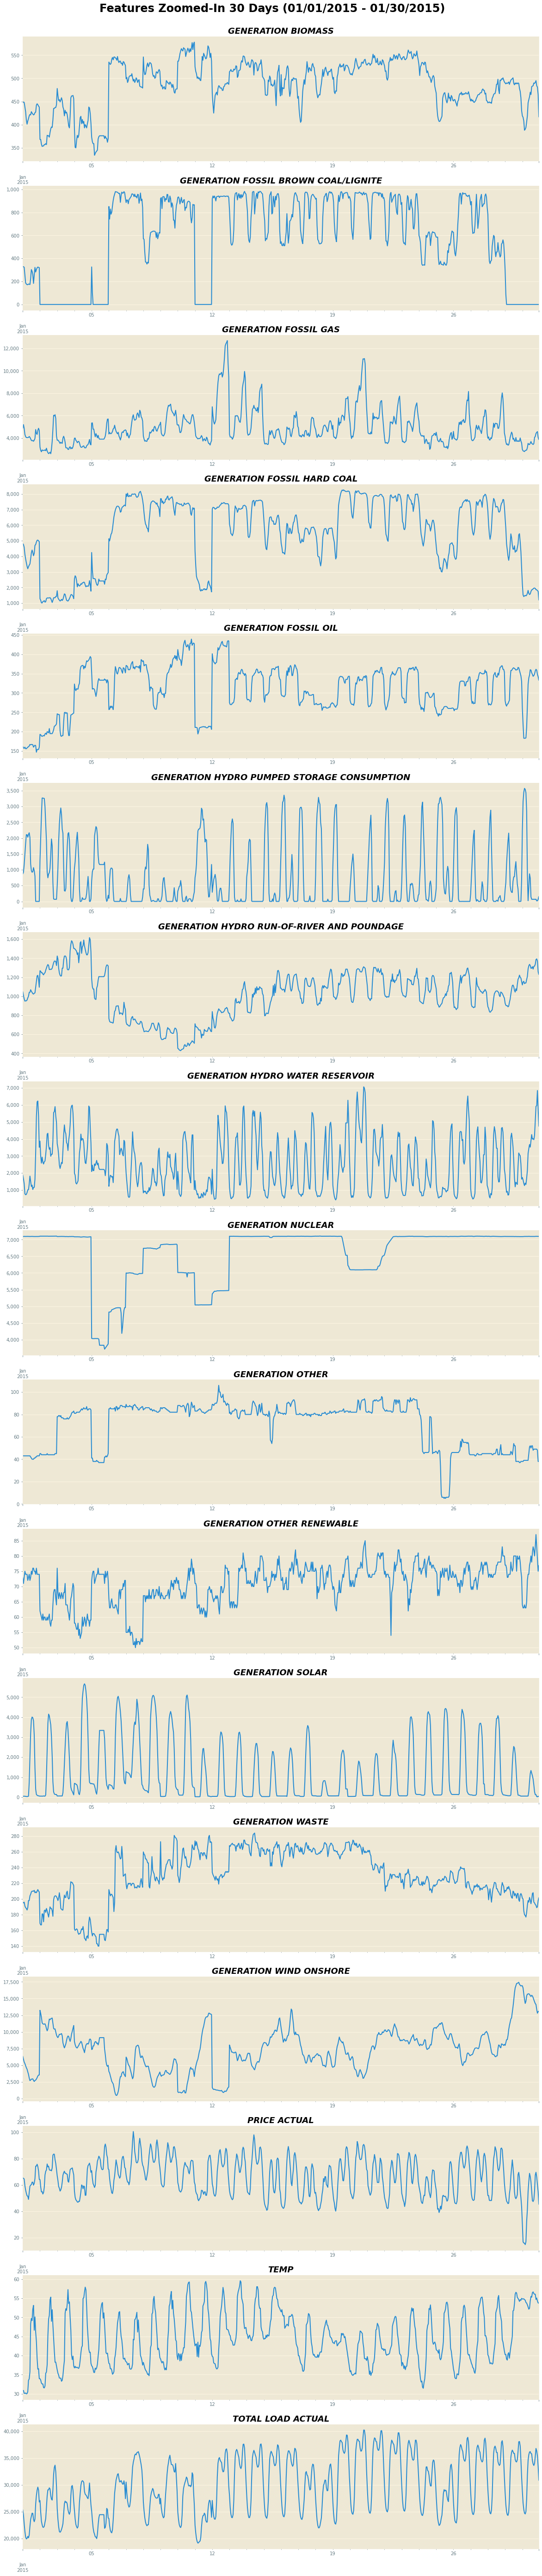

In [10]:
#Set path to EDA Visualizations
eda_path = r'C:\Users\kishe\Documents\Data Science\Projects\Python Projects\In Progress\Spain Hourly Energy Demand and Weather\Visualizations\01_Exploratory_Data_Analysis'

#Read in correlation matrix from EDA
Image(filename= eda_path + '/All_Timelots_Zoomed.png', height=3300, width=900)

**Exploring Correlations between Features**

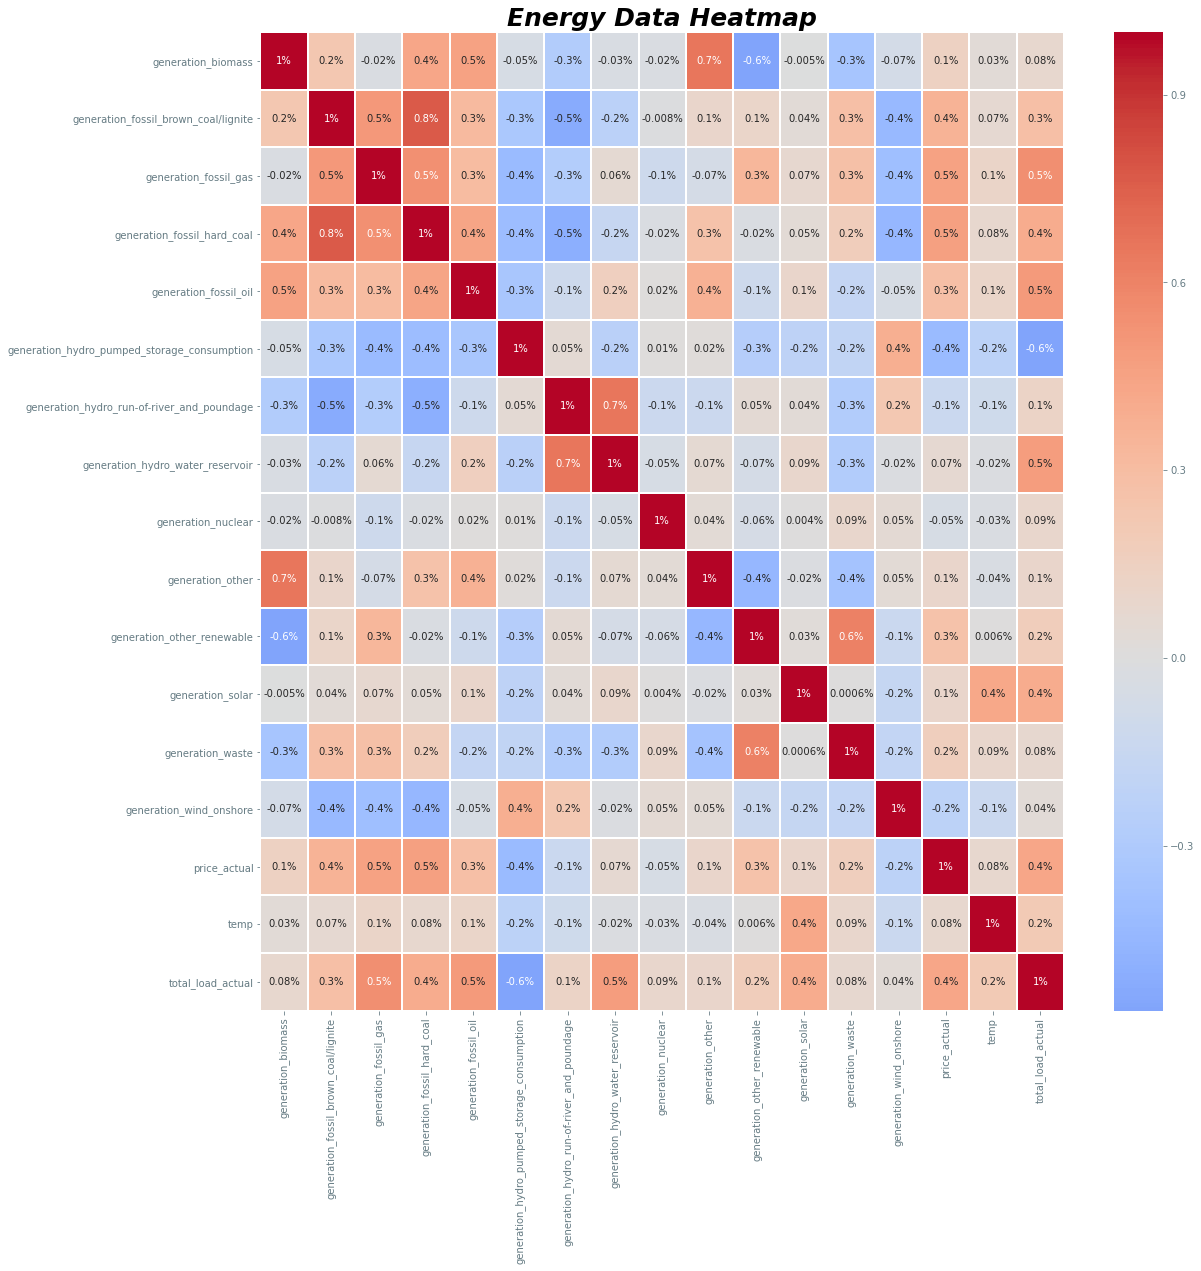

In [7]:
#Read in correlation matrix from EDA
Image(filename= eda_path + '/Correlation_Matrix.png', height=1300, width=1300)

# Consumer Profile Analysis

## Results

#

# Time Series Analysis

Base model

VAR REsults

In [8]:
XGBoost Results

SyntaxError: invalid syntax (<ipython-input-8-a04ef2bf9426>, line 1)

Tensorflow results

## Results

# Conclusion

## Final Takeaways

## Thoughts for future research